In [178]:
#imports
import math
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax.example_libraries import stax
from jax.example_libraries import optimizers
import random as rd
import pickle
import os
from flax import linen as nn
import optax
from flax.training import train_state
from flax.training import checkpoints

In [179]:
#METODA AUTOGRAD

#Definicja Lagrangianu dla podwójnego lagrangianu liczonego w sposób analityczny
#Argumenty funkcji:
#  -q   - położenie ciała
#  -q_t - prędkość ciała
#  -m1  - masa pierwszej kuli
#  -m2  - masa drugiej kuli
#  -l1  - długość pierwszej lini
#  -l2  - długość drugiej lini
#  -g   - wartość przyśpieszenia ziemskiego
#Zwracane: wartość Lagrangianu w danym momencie.
def lagrangian_analitical(q, q_t, m1, m2, l1, l2, g):
        
    # Energia kinetyczna pierwszej kuli
    Ek1 = 0.5*m1*(l1*q_t[0])**2
    # Energia kinetyczna drugiej kuli
    Ek2 = 0.5*m2*((l1*q_t[0])**2 + (l2*q_t[1])**2 + 2*l1*l2*q_t[0]*q_t[1]*jnp.cos(q[0]-q[1]))

    # Energia potencjalna obu kul
    Ep = m1*g*(-1)*l1*jnp.cos(q[0]) + m2*g*(-l1*jnp.cos(q[0]) - l2*jnp.cos(q[1]))

    return Ek1 + Ek2 - Ep

#Obliczenie energi potencjalnej i kinetycznej układu na podstawie aktualnego stanu
#Argumenty funkcji:
#  -q   - położenie ciała
#  -q_t - prędkość ciała
#  -m1  - masa pierwszej kuli
#  -m2  - masa drugiej kuli
#  -l1  - długość pierwszej lini
#  -l2  - długość drugiej lini
#  -g   - wartość przyśpieszenia ziemskiego
#Zwracane: 
#  -Ek  - Energia kinetyczna
#  -Ep  - Energia potencjalna
def compute_energy(q, q_t, m1, m2, l1, l2, g):
    # Energia kinetyczna pierwszej kuli
    Ek1 = 0.5*m1*(l1*q_t[0])**2
    # Energia kinetyczna drugiej kuli
    Ek2 = 0.5*m2*((l1*q_t[0])**2 + (l2*q_t[1])**2 + 2*l1*l2*q_t[0]*q_t[1]*jnp.cos(q[0]-q[1]))

    # Energia potencjalna obu kul
    Ep = m1*g*(-1)*l1*jnp.cos(q[0]) + m2*g*(-l1*jnp.cos(q[0]) - l2*jnp.cos(q[1]))
  

    return Ek1 + Ek2,  Ep

#Funkcja siły działającej na wahadło
def Force(t):
    return jnp.array([0, 0])

#Funkcja ma za zadanie reprezenotwanie równania różniczkowego, wynikającego z rozwiązania
#równanie Eulera-Lagrange'a
#Argumenty funkcji:
#   -lagrangian - Funkcja opisująca Lagrangian. Funkcja musi być typu ,,callable'' żeby,
#                 pochodne Lagrangianu zostały policzone.
#   -state      - Wektor zawierający wartości początkowe położenia i prędkości
#   -empty      - Aby ta funkcja mogła zostać poprawnie wywoływana w dalszej części programu
#                 koniecznym było dodanie ,,pustego'' argumentu, które nie będzie pełnił żadnej
#                 funkcji, ale pozwoli na poprawną kompilację
#Zwracane: Wektor zawiercający przyśpieszenia oraz prędkości w danym momencie.
def equation_of_motion(lagrangian, state, time=None):
    #Rozdzilenie danych startowych na położenia i prędkości
    q, q_t = jnp.split(state, 2)
    q = q.flatten()  
    q_t = q_t.flatten()
    #Obliczanie przyśpieszenia na podstawie lagrangianu
    q_tt = jax.numpy.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t)) @ (
		jax.grad(lagrangian, 0)(q, q_t)
		- jax.jacfwd(jax.grad(lagrangian, 1), 0)(q, q_t) @ q_t)
    q_tt = q_tt + Force(time)
    return jnp.concatenate([q_t, q_tt])

#Funkcja wyznaczająca trajektorię ruchu przy użyciu Lagrangianu wyznaczonego
#w sposób analityczny
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#   -m1  - masa pierwszej kuli
#   -m2  - masa drugiej kuli
#   -l1  - długość pierwszej lini
#   -l2  - długość drugiej lini
#   -g   - wartość przyśpieszenia ziemskiego
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
    lagrangian = partial(lagrangian_analitical, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
    equation = partial(equation_of_motion, lagrangian)
    return odeint(equation, initial_state, times, rtol=1e-10, atol=1e-10)


In [180]:
#Funkcja obliczająca przyśpieszenie podwójnego wahadła na podstawie aktualnego położenia i prędkości.
#Argumenty funkcji:
#   -state - Początkowego położenie oraz prędkości
#   -times - Aby ta funkcja mogła zostać poprawnie wywoływana w dalszej części programu
#            koniecznym było dodanie ,,pustego'' argumentu, które nie będzie pełnił żadnej
#            funkcji, ale pozwoli na poprawną kompilację
#   -m1  - masa pierwszej kuli
#   -m2  - masa drugiej kuli
#   -l1  - długość pierwszej lini
#   -l2  - długość drugiej lini
#   -g   - wartość przyśpieszenia ziemskiego
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
def analitical(state, time=None ,m1=1, m2=1, l1=1, l2=1, g=9.8):
    q, q_t = jnp.split(state, 2)
    
    a1 = (l2/l1)*(m2/(m1 + m2))*jnp.cos(q[0] - q[1])
    a2 = (l1/l2)*jnp.cos(q[0]-q[1])
    f1 = -(l2/l1)*(m2/(m1 + m2))*(q_t[1]**2)*jnp.sin(q[0] - q[1]) - (g/l1)*jnp.sin(q[0])
    f2 = (l1/l2)*(q_t[0]**2)*jnp.sin(q[0]-q[1]) - (g/l2) * jnp.sin(q[1])
    q_tt_1 = (f1 - a1 * f2) / (1 - a1 * a2)
    q_tt_2 = (f2 - a2 * f1) / (1 - a1 * a2)
    q_tt =  jnp.stack([q_tt_1, q_tt_2])
    
    return jnp.concatenate((jnp.expand_dims(q_t, axis=0), jnp.expand_dims(q_tt, axis=0)), axis=0)

#Funkcja wyznaczająca trajektorię ruchu obliczoną przy użyciu analitycznie wyznaczonego 
# równiania różniczkowego (funkcja analitical)
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#   -m1  - masa pierwszej kuli
#   -m2  - masa drugiej kuli
#   -l1  - długość pierwszej lini
#   -l2  - długość drugiej lini
#   -g   - wartość przyśpieszenia ziemskiego
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_analitical(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
    function = partial(analitical,m1=m1, m2=m2, l1=l1, l2=l2, g=g)
    return odeint(function, initial_state, t=times, rtol=1e-10, atol=1e-10)


In [181]:
#Punkt startowy
x0 = jnp.array([0,np.pi/2+np.pi,0,0], dtype=np.float32)
#Szum
noise = np.random.RandomState(0).randn(x0.size)
#Wektor czasów
t = np.linspace(0, 40, num=401, dtype=np.float32)

In [182]:
#Funkcja normalizująca kąt Wahadła theta do zakresu <0,2Pi>
def normalize(state):
    theta1 = state[0]  % (2 * np.pi)
    theta2 = state[1]  % (2 * np.pi)
    return jnp.array([theta1, theta2, state[2], state[3]], dtype=np.float32)

In [183]:
#WYZNACZENIE TRAJEKTORI METODĄ AUTOGRAD ORAZ ANALITYCZNĄ

#Autograd
%time autograd_clean = jax.device_get(solve_autograd(x0, t))
autograd_clean = jax.vmap(normalize)(autograd_clean)

#Autograd z małym szumem
%time autograd_noise1 = jax.device_get(solve_autograd(x0 + 1e-10*noise, t))
autograd_noise1 = jax.vmap(normalize)(autograd_noise1)

#Autograd z dużym szumem
%time autograd_noise2 = jax.device_get(solve_autograd(x0 + 1e-5*noise, t))
autograd_noise2 = jax.vmap(normalize)(autograd_noise2)

#Analitycznie 
%time analitical_clean = jax.device_get(solve_analitical(x0, t))
analitical_clean = jax.vmap(normalize)(analitical_clean)
#Analitycznie z małym szumem
%time analitical_noise1 = jax.device_get(solve_analitical(x0 + 1e-10*noise, t))
analitical_noise1 = jax.vmap(normalize)(analitical_noise1)
#Analitycznie z dużym szumem
%time analitical_noise2 = jax.device_get(solve_analitical(x0 + 1e-5*noise, t))
analitical_noise2 = jax.vmap(normalize)(analitical_noise2)

CPU times: user 1.97 s, sys: 28.5 ms, total: 2 s
Wall time: 1.57 s
CPU times: user 442 ms, sys: 267 µs, total: 443 ms
Wall time: 442 ms
CPU times: user 436 ms, sys: 0 ns, total: 436 ms
Wall time: 435 ms
CPU times: user 673 ms, sys: 10 ms, total: 683 ms
Wall time: 376 ms
CPU times: user 26.1 ms, sys: 0 ns, total: 26.1 ms
Wall time: 26.1 ms
CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 32 ms


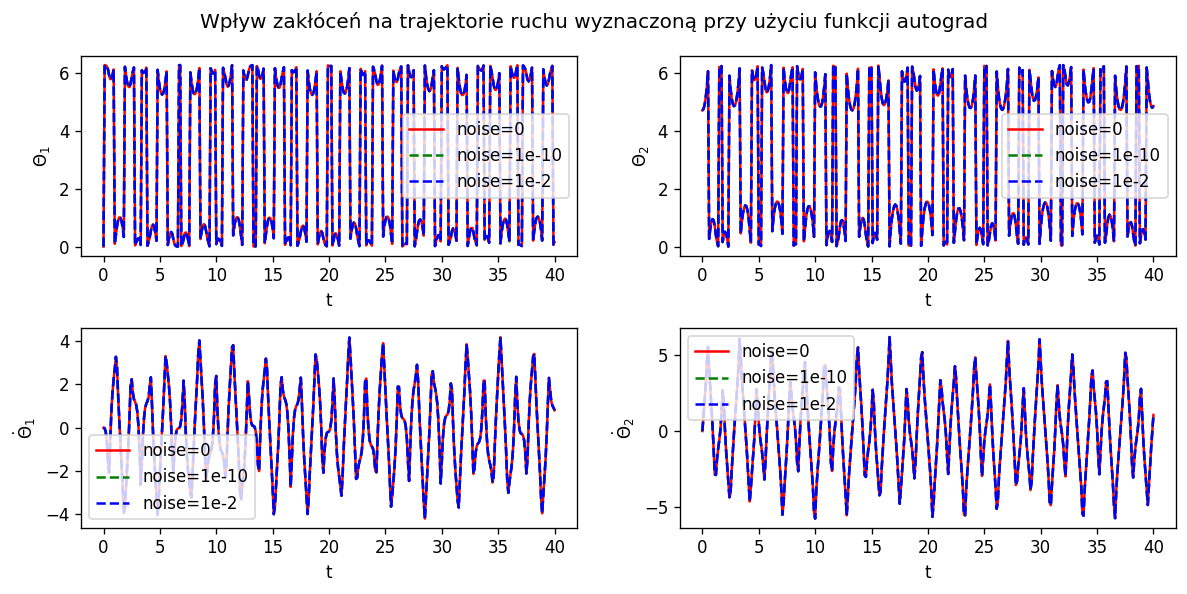

In [184]:
#WYŚWIETLENIE TRAJEKTORI (AUTOGRAD)

fig, axes = plt.subplots(2, 2, figsize=(10, 5), dpi=120)

fig.suptitle("Wpływ zakłóceń na trajektorie ruchu wyznaczoną przy użyciu funkcji autograd")

#Kąt pierwszego wahadła
axes[0,0].plot(t, autograd_clean[:, 0], 'r', label='noise=0')
axes[0,0].plot(t, autograd_noise1[:, 0], 'g--', label='noise=1e-10')
axes[0,0].plot(t, autograd_noise2[:, 0], 'b--', label='noise=1e-2')
axes[0,0].set_xlabel('t')
axes[0,0].set_ylabel('$\Theta_1$')
axes[0,0].legend()
axes[0,1].grid()

#Kąt drugiego wahadła
axes[0,1].plot(t, autograd_clean[:, 1], 'r', label='noise=0')
axes[0,1].plot(t, autograd_noise1[:, 1], 'g--', label='noise=1e-10')
axes[0,1].plot(t, autograd_noise2[:, 1], 'b--', label='noise=1e-2')
axes[0,1].set_xlabel('t')
axes[0,1].set_ylabel('$\Theta_2$')
axes[0,1].legend()
axes[0,1].grid()

#Prędkość kątowa pierwszego wahadła
axes[1,0].plot(t, autograd_clean[:, 2], 'r', label='noise=0')
axes[1,0].plot(t, autograd_noise1[:, 2], 'g--', label='noise=1e-10')
axes[1,0].plot(t, autograd_noise2[:, 2], 'b--', label='noise=1e-2')
axes[1,0].set_xlabel('t')
axes[1,0].set_ylabel('$\dot \Theta_1$')
axes[1,0].legend()
axes[1,1].grid()

#Prędkość prędkość kątowa drugiego wahadła
axes[1,1].plot(t, autograd_clean[:, 3], 'r', label='noise=0')
axes[1,1].plot(t, autograd_noise1[:, 3], 'g--', label='noise=1e-10')
axes[1,1].plot(t, autograd_noise2[:, 3], 'b--', label='noise=1e-2')
axes[1,1].set_xlabel('t')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].legend()
axes[1,1].grid()

plt.tight_layout()

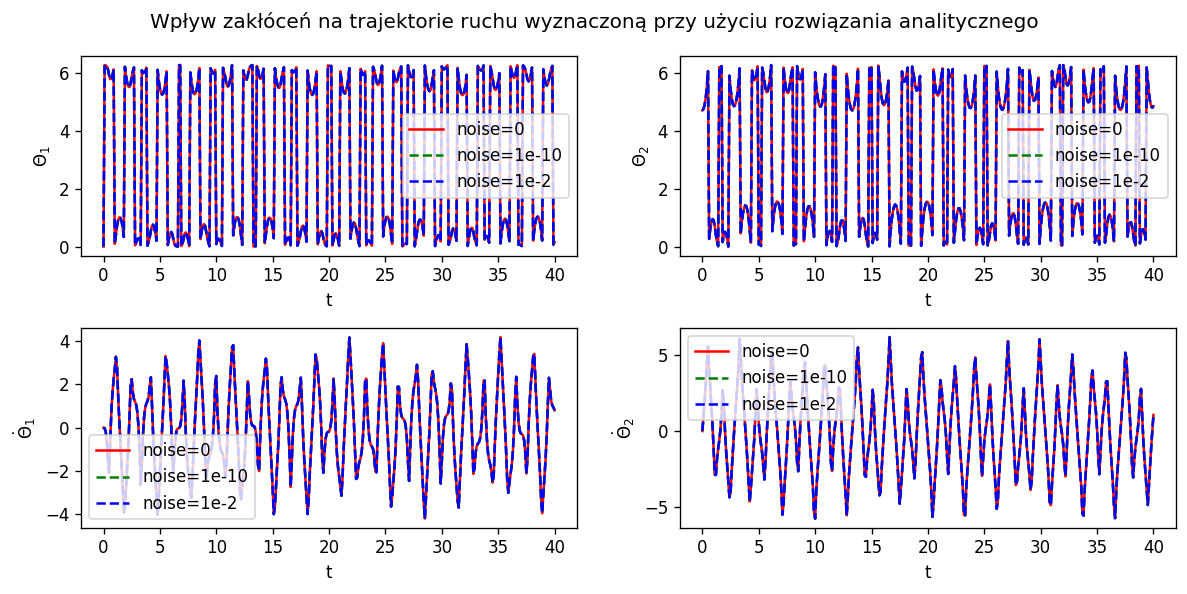

In [185]:
#WYŚWIETLENIE TRAJEKTORI (METODA ANALITYCZNA)

fig, axes = plt.subplots(2, 2, figsize=(10, 5), dpi=120)

fig.suptitle("Wpływ zakłóceń na trajektorie ruchu wyznaczoną przy użyciu rozwiązania analitycznego")

#Kąt pierwszego wahadła
axes[0,0].plot(t, analitical_clean[:, 0], 'r', label='noise=0')
axes[0,0].plot(t, analitical_noise1[:, 0], 'g--', label='noise=1e-10')
axes[0,0].plot(t, analitical_noise2[:, 0], 'b--', label='noise=1e-2')
axes[0,0].set_xlabel('t')
axes[0,0].set_ylabel('$\Theta_1$')
axes[0,0].legend()
axes[0,1].grid()

#Kąt drugiego wahadła
axes[0,1].plot(t, analitical_clean[:, 1], 'r', label='noise=0')
axes[0,1].plot(t, analitical_noise1[:, 1], 'g--', label='noise=1e-10')
axes[0,1].plot(t, analitical_noise2[:, 1], 'b--', label='noise=1e-2')
axes[0,1].set_xlabel('t')
axes[0,1].set_ylabel('$\Theta_2$')
axes[0,1].legend()
axes[0,1].grid()

#Prędkość kątowa pierwszwego wahadła
axes[1,0].plot(t, analitical_clean[:, 2], 'r', label='noise=0')
axes[1,0].plot(t, analitical_noise1[:, 2], 'g--', label='noise=1e-10')
axes[1,0].plot(t, analitical_noise2[:, 2], 'b--', label='noise=1e-2')
axes[1,0].set_xlabel('t')
axes[1,0].set_ylabel('$\dot \Theta_1$')
axes[1,0].legend()
axes[1,1].grid()

#Prędkość kątowa drugiego wahadła
axes[1,1].plot(t, analitical_clean[:, 3], 'r', label='noise=0')
axes[1,1].plot(t, analitical_noise1[:, 3], 'g--', label='noise=1e-10')
axes[1,1].plot(t, analitical_noise2[:, 3], 'b--', label='noise=1e-2')
axes[1,1].set_xlabel('t')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].legend()
axes[1,1].grid()

plt.tight_layout()

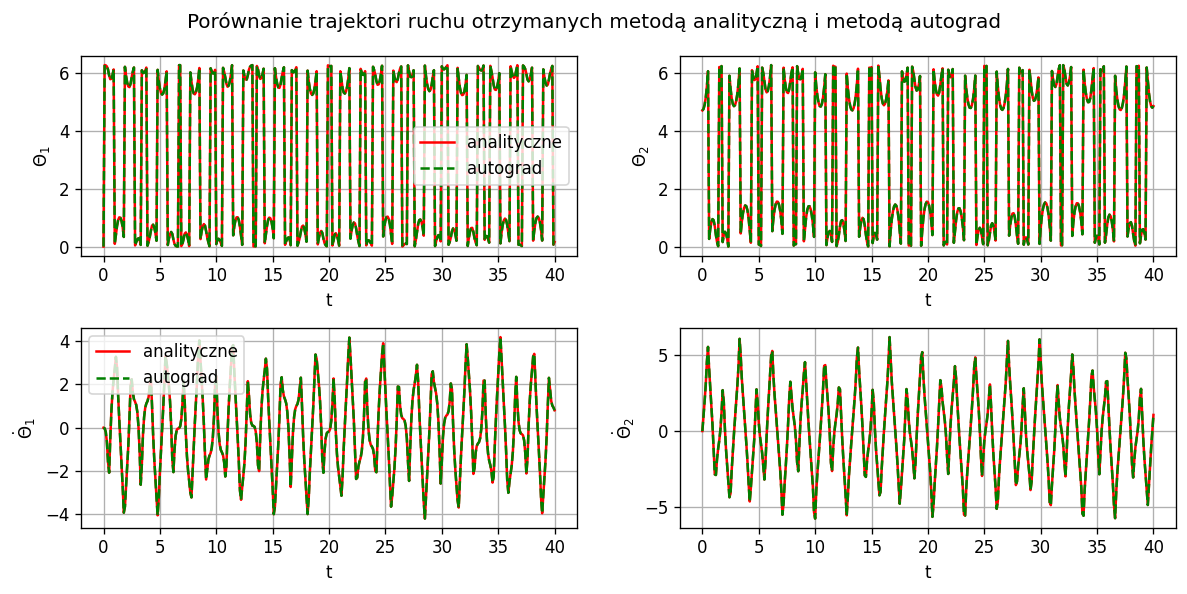

In [186]:
#PORÓWNANIE TRAJEKTORI OTRZYMANYCH PRZY UŻYCIU OBU METOD

fig, axes = plt.subplots(2, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie trajektori ruchu otrzymanych metodą analityczną i metodą autograd')


#Kąt pierwszwego wahadła
axes[0,0].plot(t, analitical_clean[:, 0], 'r', label='analityczne')
axes[0,0].plot(t, autograd_clean[:, 0], 'g--', label='autograd')
axes[0,0].set_xlabel('t')
axes[0,0].set_ylabel('$\Theta_1$')
axes[0,0].legend()
axes[0,0].grid()

#Kąt drugiego wahadła
axes[0,1].plot(t, analitical_clean[:, 1], 'r', label='analityczne')
axes[0,1].plot(t, autograd_clean[:, 1], 'g--', label='autograd')
axes[0,1].set_xlabel('t')
axes[0,1].set_ylabel('$\Theta_2$')
axes[0,1].grid()

#Prędkość kątowa pierwszego wahadała
axes[1,0].plot(t, analitical_clean[:, 2], 'r', label='analityczne')
axes[1,0].plot(t, autograd_clean[:, 2], 'g--', label='autograd')
axes[1,0].set_xlabel('t')
axes[1,0].set_ylabel('$\dot \Theta_1$')
axes[1,0].legend()
axes[1,0].grid()

#Prędkość kątowa drugiego wahadła
axes[1,1].plot(t, analitical_clean[:, 3], 'r', label='analityczne')
axes[1,1].plot(t, autograd_clean[:, 3], 'g--', label='autograd')
axes[1,1].set_xlabel('t')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].grid()


plt.tight_layout()

[[ 6.0665107e-01 -1.3219329e+00 -9.9287964e-02 -8.4459579e-01]
 [ 5.6023479e-01 -3.1511273e+00 -3.0770367e-01  1.6678168e-01]
 [ 1.2975903e-02  1.8924849e-01 -8.3708569e-02 -9.3266219e-01]
 [ 1.7265366e-01 -2.4570948e-01 -4.6458983e-01  1.8865189e-01]
 [-5.2923238e-01 -6.5638429e-01  9.3260175e-01  9.7460306e-01]
 [ 2.5078807e+00  1.8017339e+00  3.6873907e-01 -5.8412892e-01]
 [-1.1944247e+00 -1.8630079e+00 -8.4933931e-01 -9.9265212e-01]
 [-2.9556487e+00 -2.8386579e+00  7.0077074e-01 -3.9345115e-01]
 [ 4.0911514e-01 -2.4338310e+00  6.3627088e-01 -6.7704779e-01]
 [ 2.4735122e+00  2.5017459e+00  2.4234941e-02  8.8691622e-01]
 [ 3.2368479e+00 -1.1241347e+00 -3.4642223e-01 -8.0368215e-01]
 [ 2.3088140e+00  1.6856608e+00 -4.4588378e-01 -7.2512883e-01]
 [ 2.3164852e+00 -3.3618352e-01 -9.8833239e-01 -2.0963554e-01]
 [-1.3702927e+00  2.9938660e+00  3.3684403e-01  7.8509316e-02]
 [-3.2239804e+00 -2.4839599e-01 -5.2133363e-01  9.6235639e-01]
 [-2.2239454e-01 -1.9079593e+00  8.4795815e-01 -5.07626

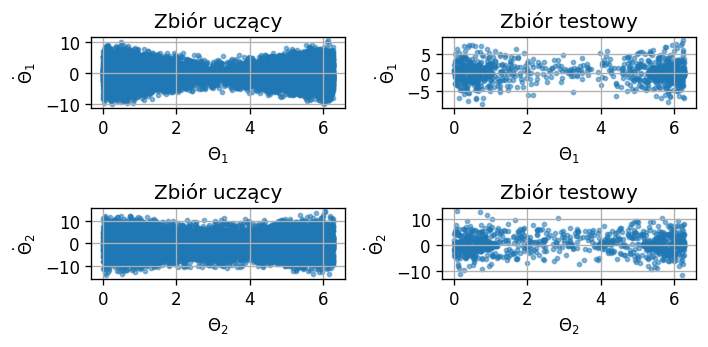

In [187]:
#Budowa zbioru uczącego i testowego
N = 100             #liczba próbek pobieranych z jednej trajektorii
time_step = 0.2     #okres próbkowania
Num_X0_train = 100  #liczba trajektorii dla zbioru uczącego
Num_X0_test = 10    #liczba trajektorii dla zbioru testowego

x0_train = np.zeros([Num_X0_train, 4],  dtype=jnp.float32)
x0_test = np.zeros([Num_X0_test, 4],  dtype=jnp.float32)

#ZAKRESY
#Theta1 = <-Pi,Pi>
#Theta2 = <-Pi, Pi>
#Theta'1 = <-1, 1>
#Theta'2 = <-1, 1>

eps = 0.1

#Punkty startowe dla trajektorii dla zbioru uczącego
x0_train[:,0] = np.random.rand(Num_X0_train)*2*(np.pi + eps) - (np.pi + eps)
x0_train[:,1] = np.random.rand(Num_X0_train)*2*(np.pi + eps) - (np.pi + eps)
x0_train[:,2] = np.random.rand(Num_X0_train)*2*1 - 1
x0_train[:,3] = np.random.rand(Num_X0_train)*2*1 - 1

#Punkty startowe dla trajektorii dla zbioru testowego
x0_test[:,0] = np.random.rand(Num_X0_test)*2*(np.pi + eps) - (np.pi + eps)
x0_test[:,1] = np.random.rand(Num_X0_test)*2*(np.pi + eps) - (np.pi + eps)
x0_test[:,2] = np.random.rand(Num_X0_test)*2*1 - 1
x0_test[:,3] = np.random.rand(Num_X0_test)*2*1 - 1

print(x0_train)
print(x0_test)
t = jnp.linspace(0, N * time_step, num=N, dtype=jnp.float32)

x_train = jnp.zeros([x0_train.shape[0]*N, 4])
y_train = jnp.zeros([x0_train.shape[0]*N, 4])
x_test = jnp.zeros([x0_test.shape[0]*N, 4])
y_test = jnp.zeros([x0_test.shape[0]*N, 4])

fig, axes = plt.subplots(2, 2, figsize=(6, 3), dpi=120)


#Budowa zbioru uczącego
for i in range(x0_train.shape[0]):
    trajectory = jax.device_get(solve_analitical(x0_train[i], t))
    trajectory = jax.vmap(normalize)(trajectory)
    x_train = x_train.at[i * N:(i + 1)*N, 0:4].set(trajectory)
    

    accelerations = jax.vmap(analitical)(trajectory)
    accelerations = jax.device_get(accelerations)
    y_train = y_train.at[i * N:(i + 1)*N, 0:2].set(accelerations[:,0,:])
    y_train = y_train.at[i * N:(i + 1)*N, 2:4].set(accelerations[:,1,:])

axes[0,0].scatter(x_train[:, 0], x_train[:, 2], s=6, alpha=0.5)
axes[1,0].scatter(x_train[:, 1], x_train[:, 3], s=6, alpha=0.5)

#Budowa zbioru testowego
for i in range(x0_test.shape[0]):
    trajectory = jax.device_get(solve_analitical(x0_test[i], t))
    trajectory = jax.vmap(normalize)(trajectory)
    x_test = x_test.at[i * N:(i + 1) * N, 0:4].set(trajectory)

    accelerations = jax.vmap(analitical)(trajectory)
    accelerations = jax.device_get(accelerations)
    y_test = y_test.at[i * N:(i + 1) * N, 0:2].set(accelerations[:,0,:])
    y_test = y_test.at[i * N:(i + 1) * N, 2:4].set(accelerations[:,1,:])


#Wizualizacja zbioru
axes[0,1].scatter(x_test[:, 0], x_test[:, 2], s=6, alpha=0.5)
axes[1,1].scatter(x_test[:, 1], x_test[:, 3], s=6, alpha=0.5)

axes[0,0].set_xlabel('$\Theta_1$')
axes[0,0].set_ylabel('$\dot \Theta_1$')
axes[0,0].set_title('Zbiór uczący')
axes[0,0].grid()

axes[1,0].set_xlabel('$\Theta_2$')
axes[1,0].set_ylabel('$\dot \Theta_2$')
axes[1,0].set_title('Zbiór uczący')
axes[1,0].grid()

axes[0,1].set_xlabel('$\Theta_1$')
axes[0,1].set_ylabel('$\dot \Theta_1$')
axes[0,1].set_title('Zbiór testowy')
axes[0,1].grid()

axes[1,1].set_xlabel('$\Theta_2$')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].set_title('Zbiór testowy')
axes[1,1].grid()

plt.tight_layout()

In [ ]:
#ARCHITEKUTRA SIECI NEURONOWEJ
layers=[4,32,32,32,1]


class NeuralNetwork(nn.Module):
  input_size:int
  output_size:int
  hidden_layer:int
  layer_size:int
  
  def setup(self):
    
    kernel_init = nn.initializers.variance_scaling(scale=2.0, mode='fan_avg', distribution='truncated_normal')
    self.Dense = [nn.Dense(features=self.layer_size, kernel_init=kernel_init) for i in range(self.hidden_layer)]
    self.Output = nn.Dense(self.output_size, kernel_init=kernel_init)

 
  def __call__(self, x):
    for i in range(self.hidden_layer):
      x = self.Dense[i](x)
      x = nn.softplus(x)
    x = self.Output(x)
    return x
  
  def init_params(self, key):
    variables = self.init(key, jnp.ones((self.input_size)))
    return variables['params']
  
  def learned_lagrangian(self, params):
    def lagrangian(q, q_t):
        assert q.shape == (2,)
        state = jnp.concatenate([q, q_t])
        return jnp.squeeze(self.apply({'params': params}, state), axis=-1)
    return lagrangian
  


def MSE_loss(train_state, params, state, targets):
  preds = jax.vmap(partial(equation_of_motion, train_state.apply_fn(params)))(state)
  return jnp.mean((preds - targets) ** 2)


@jax.jit  
def train_step(train_state, state, targets):
    
    grad_fn = jax.value_and_grad(MSE_loss, argnums=1)
    
    loss, grads = grad_fn(train_state, train_state.params, state, targets)
    
    train_state = train_state.apply_gradients(grads=grads)
    
    return train_state, loss
  


def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

In [ ]:
%%time

Training = True    
Epochs = 1000      
StopError = 0.001  
learning_rate = 1e-2  
batch_size = 64

train_error = []   
test_error = []    

model = NeuralNetwork(input_size=4, output_size=1, hidden_layer=4, layer_size=128)
rng = jax.random.PRNGKey(0)
params_initial = model.init_params(rng)


optimizer = optax.adam(learning_rate=learning_rate)
model_state = train_state.TrainState.create(apply_fn=model.learned_lagrangian,
                                            params=params_initial,
                                            tx=optimizer)


ckpt_dir = os.path.abspath('Checkpoints')



if Training:
    x_train, x_test, y_train, y_test = map(jax.device_get, [x_train, x_test, y_train, y_test])
    n_samples =  x_train.shape[0]

    best_error = float('inf')

    for i in range(Epochs):
        
        x_train, y_train = shuffle(x_train, y_train)
        start = 0
        loss = 0
        full_batch = 0
        
        while start < n_samples:
            end = start + batch_size
            x_batch = x_train[start:end, :]
            y_batch = y_train[start:end, :]

            
            model_state, act_loss = train_step(model_state, x_batch, y_batch)
            loss += act_loss
            start += batch_size

        
        train_error.append(loss / (float(start+batch_size) /  float(batch_size)))
        test_error.append(MSE_loss(model_state, model_state.params, x_test, y_test))

        
        if test_error[-1] < best_error:
            best_error = test_error[-1]
            best_params = model_state.params

        
        if test_error[-1] <= StopError:
            print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}, best_loss={best_error:.6f}")
            break

        
        if i % 1 == 0:
            print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}, best_loss={best_error:.6f}")

   
    params = best_params
    checkpoints.save_checkpoint(ckpt_dir=ckpt_dir,  # Folder to save checkpoint in
                            target=model_state,  # What to save. To only save parameters, use model_state.params
                            step=len(test_error),  # Training step or other metric to save best model on
                            prefix='podwojne_wahadlo',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )
else:
    loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir=ckpt_dir,   # Folder with the checkpoints
                                             target=model_state,   # (optional) matching object to rebuild state in
                                             prefix='podwojne_wahadlo'  # Checkpoint file name prefix
                                            )
    params = model_state.params
    


iteration=0, train_loss=271.783630, test_loss=117.760551, best_loss=117.760551
iteration=1, train_loss=176.887115, test_loss=114.615303, best_loss=114.615303
iteration=2, train_loss=172.558319, test_loss=111.492271, best_loss=111.492271
iteration=3, train_loss=169.181534, test_loss=108.651924, best_loss=108.651924
iteration=4, train_loss=166.320450, test_loss=106.200706, best_loss=106.200706
iteration=5, train_loss=163.114044, test_loss=104.110992, best_loss=104.110992
iteration=6, train_loss=160.727310, test_loss=102.153946, best_loss=102.153946
iteration=7, train_loss=158.278137, test_loss=99.758842, best_loss=99.758842
iteration=8, train_loss=154.778168, test_loss=96.671440, best_loss=96.671440
iteration=9, train_loss=150.560150, test_loss=91.517525, best_loss=91.517525
iteration=10, train_loss=174.867722, test_loss=98.960732, best_loss=91.517525
iteration=11, train_loss=160.394073, test_loss=98.698753, best_loss=91.517525
iteration=12, train_loss=160.075684, test_loss=98.430641, be

In [ ]:
#Funkcja wyznaczająca trajektorię ruchu przy użyciu Lagrangianu zamodlowanego za pomocą sieci neuronowej
#Argumenty funkcji:
#   -params        - Parametry sieci neuronowej
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_lagrangian(model, params, initial_state, times):
  return odeint(partial(equation_of_motion, model.learned_lagrangian(params)),
                  initial_state, times, rtol=1e-10, atol=1e-10)
  
  
#Funkcja ma za zadanie obliczenie przyśpieszenia na podstawie aktualnego stanu
#(położenie i przyśpieszenie) przy użyciu lagrangianu zamodelowanego przez sieć LNN.
#Argumenty funkcji:
#   -params     - Parametry sieci.
#   -state      - Wektor zawierający wartości początkowe położenia i prędkości [q, q_t].
#Zwracane:  Przyśpieszenie wynikającego z aktulanego wektora stanu.  
@partial(jax.jit, backend='cpu')
def acceleration_learned(model, params, initial_state):
  acc = partial(equation_of_motion, model.learned_lagrangian(params))
  return acc(initial_state)[2:4]

In [ ]:
#WIZUALIZACJA BŁĘDU MSE PODCZAS UCZENIA SIECI
'''
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_error[:], 'r', label='Train loss')
plt.plot(test_error[:], 'g', label='Test loss')
plt.yscale('log')
plt.title('Błąd średniokwadratowy podczas uczenia sieci')
plt.xlabel("Epoka") 
plt.ylabel("Błąd MSE")
plt.grid()
plt.legend() 
plt.show()'''

'\nplt.figure(figsize=(8, 3.5), dpi=120)\nplt.plot(train_error[:], \'r\', label=\'Train loss\')\nplt.plot(test_error[:], \'g\', label=\'Test loss\')\nplt.yscale(\'log\')\nplt.title(\'Błąd średniokwadratowy podczas uczenia sieci\')\nplt.xlabel("Epoka") \nplt.ylabel("Błąd MSE")\nplt.grid()\nplt.legend() \nplt.show()'

In [ ]:
#TEST PREDYKCJI SIECI

#Obliczenie predykcji sieci (wartość wyjściowa) na podstawie zbioru testowego
y_pred = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_test)

#Wizualizacji wyników
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=120)
fig.suptitle("Porównanie oczekiwanych wyników z wynikami predykcji")
axes[0,0].scatter(y_test[:, 0], y_pred[:, 0], s=6, alpha=1)
axes[0,0].set_xlabel('oczkiwane $\dot \Theta_1$')
axes[0,0].set_ylabel('predykcja $\dot \Theta_1$')
axes[0,0].grid()
axes[0,1].scatter(y_test[:, 1], y_pred[:, 1], s=6, alpha=1)
axes[0,1].set_xlabel('oczkiwane $\dot \Theta_2$')
axes[0,1].set_ylabel('predykcja $\dot \Theta_2$')
axes[0,1].grid()
axes[1,0].scatter(y_test[:, 2], y_pred[:, 2], s=6, alpha=1)
axes[1,0].set_xlabel('oczkiwane $\ddot \Theta_1$')
axes[1,0].set_ylabel('predykcja $\ddot \Theta_1$')
axes[1,0].grid()
axes[1,1].scatter(y_test[:, 3], y_pred[:, 3], s=6, alpha=1)
axes[1,1].set_xlabel('oczkiwane $\ddot \Theta_2$')
axes[1,1].set_ylabel('predykcja $\ddot \Theta_2$')
axes[1,1].grid()
plt.tight_layout()

NameError: name 'learned_lagrangian' is not defined

In [ ]:
#Punkt startowy
x0 = jnp.array([0,0.1,0,0], dtype=np.float32)
#Szum
noise = np.random.RandomState(0).randn(x0.size)
#Wektor czasów
t = np.linspace(0, 40, num=401, dtype=np.float32)


%time trajectory_autograd = jax.device_get(solve_autograd(x0, t))

%time trajectory_LNN = jax.device_get(solve_lagrangian(params, x0, t))

CPU times: user 154 ms, sys: 0 ns, total: 154 ms
Wall time: 152 ms
CPU times: user 1min 9s, sys: 109 ms, total: 1min 9s
Wall time: 1min 7s


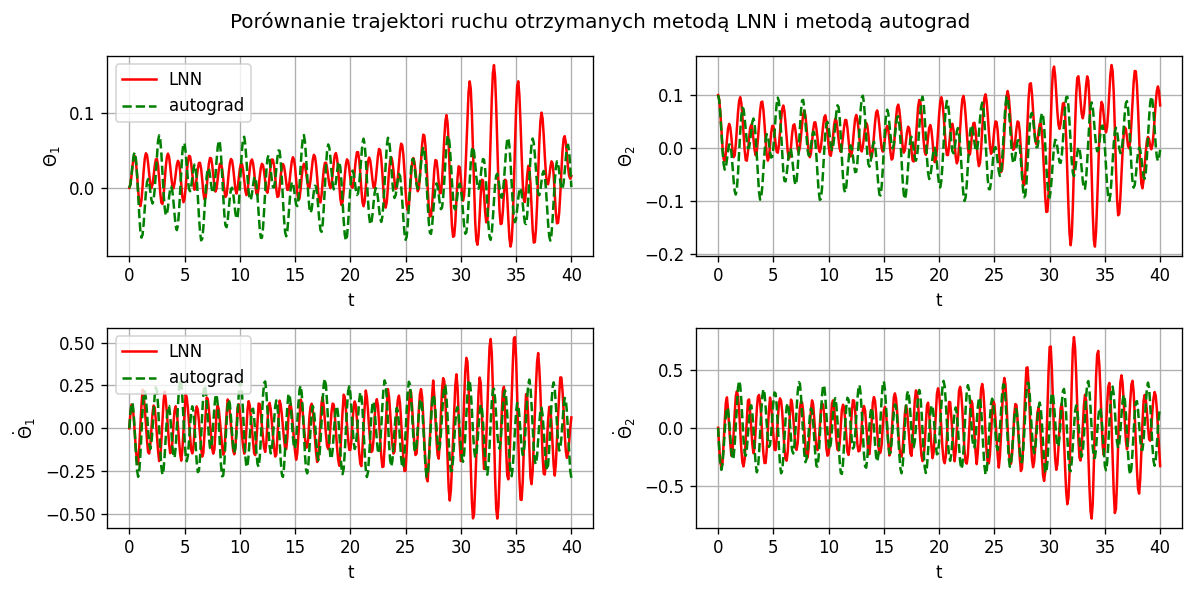

In [ ]:
#PORÓWNANIE TRAJEKTORI OTRZYMANYCH PRZY UŻYCIU OBU METOD

fig, axes = plt.subplots(2, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie trajektori ruchu otrzymanych metodą LNN i metodą autograd')


#Kąt pierwszwego wahadła
axes[0,0].plot(t, trajectory_LNN[:, 0], 'r', label='LNN')
axes[0,0].plot(t, trajectory_autograd[:, 0], 'g--', label='autograd')
axes[0,0].set_xlabel('t')
axes[0,0].set_ylabel('$\Theta_1$')
axes[0,0].legend()
axes[0,0].grid()

#Kąt drugiego wahadła
axes[0,1].plot(t, trajectory_LNN[:, 1], 'r', label='LNN')
axes[0,1].plot(t, trajectory_autograd[:, 1], 'g--', label='autograd')
axes[0,1].set_xlabel('t')
axes[0,1].set_ylabel('$\Theta_2$')
axes[0,1].grid()

#Prędkość kątowa pierwszego wahadała
axes[1,0].plot(t, trajectory_LNN[:, 2], 'r', label='LNN')
axes[1,0].plot(t, trajectory_autograd[:, 2], 'g--', label='autograd')
axes[1,0].set_xlabel('t')
axes[1,0].set_ylabel('$\dot \Theta_1$')
axes[1,0].legend()
axes[1,0].grid()

#Prędkość kątowa drugiego wahadła
axes[1,1].plot(t, trajectory_LNN[:, 3], 'r', label='LNN')
axes[1,1].plot(t, trajectory_autograd[:, 3], 'g--', label='autograd')
axes[1,1].set_xlabel('t')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].grid()


plt.tight_layout()